- [4.1 Overview](#4_1)
- [4.2 Imports and Loading](#4_2)
- [4.3 Preprocessing](#4_3)
- [4.4 Modeling](#4_4)
    - [4.4.1 Linear Regression]
    - [4.4.2]
- [4.5 Evaluation](#4_5)

## 4.1 Overview
- We now conduct preprocessing and feature selection to find variables that's important to predicting our job satisfaction (overall_rating)
- Our goal is to use models to define `correlation/drivers` a users sentiment have towards their job (overall_rating) based on their rating towards different aspects of their life, the industries and level of management they are in, and based off of their reviews of their jobs

## 4.2 Imports and Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline


### Run lineaer just in case, (people may ask about skipping it) (r2) (which models has smallest rsme)
### justification for models you use
### tree based models, distance between model outputs (no goodness of fit of model, look at the error (true satisfaction vs model satifaction))
    ### 80% fits the model well, apply model on test set

### Debate building models and find correlation vs models to predict
    ### Main goal is correlation and find drivers, run it through test set. Train data on everything and make sure model fits well. @@@ r^2 (linear) and rsme (in both)
    ### research evaluation metrics as well.
    ### If predicting, than I would make sure it fits well on test set.
    ### Play if ratings if anything above 3 bad, higher 3 good. Then i can use logistic regression, (Help us get more signal, less response variable) 
        ### Classification is more popular (customer churn, buy, etc based on binary and help simplify problems)
    ### XGboost (overtook svm, look into shap)

### experiment design for next segment
    ### refresher on stats
    ### hypothesis what you want to test (think about questions), find datasets to work with. Maybe take this hypothesis test on test, see if employees in tech is better than others.
    ### do statistical test on this (control and treatment, you can make your own treatments)
        ### ideas: democratic/republican, left/right handed smarter, etc.

### in terms of topics, deep learning not yet (helpful to know it, but not the main)
    ### Andrew Ng's deep learning course, some ml models much more efficient outcome (not as much in applied ds roles)
    ### newsletter outline for this week for ML

In [4]:
df = pd.read_csv('/Users/Andre/OneDrive/Desktop/1_Glassdoor_Project/CleanedData/clean_data_2.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242755 entries, 0 to 242754
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           242755 non-null  object 
 1   firm               242755 non-null  object 
 2   job_title          242702 non-null  object 
 3   level              242755 non-null  int64  
 4   status             140598 non-null  float64
 5   years              98024 non-null   float64
 6   location           242755 non-null  object 
 7   overall_rating     242755 non-null  int64  
 8   work_life_balance  242755 non-null  float64
 9   culture_values     242755 non-null  float64
 10  career_opp         242755 non-null  float64
 11  comp_benefits      242755 non-null  float64
 12  senior_mgmt        242755 non-null  float64
 13  headline           242755 non-null  object 
 14  pros               242755 non-null  object 
 15  cons               242755 non-null  object 
 16  co

In [4]:
df.head(5)

,industry,firm,level,job_title,status,years,location,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,headline,pros,cons,processed_text,word_count,char_count,sentiment_score
0,Tech,IBM,2,Test Lead,0.0,1.0,"Halifax, NS",1,1.0,1.0,4.0,2.0,1.0,Very bad place to work,IBM provides lot of training to employees,"Salary, They treat employees very bad. Employe...",bad place work IBM provide lot training employ...,14,98,-0.6486
1,Tech,IBM,1,Associate Systems Engineer,0.0,0.5,Bangalore,3,4.0,3.0,3.0,1.0,2.0,Associate System Engineer,"Good Work Life Balance, Cool Projects.Employee...",NO HIKE. AN IBM EMPLOYEE DOESN'T HAVE RIGHT T...,associate System Engineer Good Work Life Balan...,50,344,0.9425
2,Tech,IBM,3,Program Director,1.0,0.5,"Tampa, FL",2,1.0,1.0,1.0,2.0,1.0,IBM - the people are great - Company could car...,"Amazing, talented, people. Everything that is ...",IBM the corporation does not value their emplo...,IBM people great company care amazing talented...,18,125,0.9571
3,Tech,IBM,2,Technical Support Engineer,1.0,3.0,Hyderābād,1,3.0,1.0,1.0,3.0,1.0,Soulless company,Good to have it on your resume,- no culture \r\n- no real career path\r\n- yo...,soulless company Good resume culture \r\n real...,11,89,0.0258
4,Tech,IBM,3,Senior Software Engineer,1.0,NaN,"Research Triangle Park, NC",3,5.0,4.0,4.0,4.0,2.0,an OK place to work,"tech leader, constant encouragement to continu...",executive level management will cut budgets an...,ok place work tech leader constant encourageme...,21,146,0.7351


## 4.3 Data Preprocessing
- Make we process all NaN values
- Hot encode/Imput any values if necessary

### 4.3.1 Imputing, NaN Handling, Preparing for training

In [5]:
## Remove job_title rows NA values
## As we looked at in the EDA, status and years has minimal effect on our overall_rating and majority is NaN. We should drop these columns
df.isnull().sum()

industry                 0
firm                     0
level                    0
job_title               34
status               67939
years                92463
location                 0
overall_rating           0
work_life_balance        0
culture_values           0
career_opp               0
comp_benefits            0
senior_mgmt              0
headline                 0
pros                     0
cons                     0
processed_text           0
word_count               0
char_count               0
sentiment_score          0
dtype: int64

In [6]:
### Also headline, pros, and cons columns have been processed already so we can drop this for our model
### Futhermore, word and char count is insignificant too.
df.dropna(subset=['job_title'], inplace= True)
df.drop(columns=['headline','pros','cons','status','years','word_count','char_count'], inplace = True)

### We are also interested in the industy and level trends,  firm name, job_title, and location can be forgone for our model
df.drop(columns=['firm','job_title','location'], inplace = True)

df.isnull().sum()

industry             0
level                0
overall_rating       0
work_life_balance    0
culture_values       0
career_opp           0
comp_benefits        0
senior_mgmt          0
processed_text       0
sentiment_score      0
dtype: int64

We don't have any numerical columns in need of imputing, we selected our values before

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150186 entries, 0 to 150219
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           150186 non-null  object 
 1   level              150186 non-null  int64  
 2   overall_rating     150186 non-null  int64  
 3   work_life_balance  150186 non-null  float64
 4   culture_values     150186 non-null  float64
 5   career_opp         150186 non-null  float64
 6   comp_benefits      150186 non-null  float64
 7   senior_mgmt        150186 non-null  float64
 8   processed_text     150186 non-null  object 
 9   sentiment_score    150186 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.6+ MB


### 4.3.3 Test/Train Split

In [8]:
X = df.drop(columns=['overall_rating'])
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.3.4 Feature Seperation
- Let's seperate our features into numerical, categorical, and text columns

In [26]:
numerical_features = ['work_life_balance', 'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'level', 'sentiment_score']
numerical_transformer = StandardScaler()

categorical_features = ['industry']
categorical_transformer = OneHotEncoder()

text_features = 'processed_text'
text_transformer = TfidfVectorizer(max_features=5000)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)
    ]
)

### Dimensionality Reduction

In [27]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
X_train_svd = svd.fit_transform(preprocessor.fit_transform(X_train))
X_test_svd = svd.transform(preprocessor.transform(X_test))

## 4.5 Model Training

### 4.5.1 Linear Regression

In [28]:
#Linear regression
lg_pipeline = make_pipeline(preprocessor, LinearRegression())
lg_pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(lg_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("Cross-validation RMSE:", np.sqrt(-cv_scores).mean())

# Evaluate the model on the test set
y_pred = lg_pipeline.predict(X_test)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R²: {r2}")

Cross-validation RMSE: 0.602428317060703
Linear Regression RMSE: 0.600717206506581
Linear Regression R²: 0.7272021840874573


Good score?

### 4.5.2 Logisitics Regression
We can also perform logistics regression, by seperating our overall ratings into 2 categories: 1 (ratings of 5,4) and 0 (3,2,1)

In [39]:
# Convert our values to binary
key = {5: 1, 4: 1, 3: 0, 2: 0, 1: 0}

y_train_log = y_train.map(key)
y_test_log = y_test.map(key)

print(y_train_log.nunique())
print(y_test_log.nunique())


2
2


Accuracy: 0.8744673295454546
Precision: 0.8914058851004204
Recall: 0.9175480769230769
F1 Score: 0.9042880833925611
AUC: 0.8566467794253939


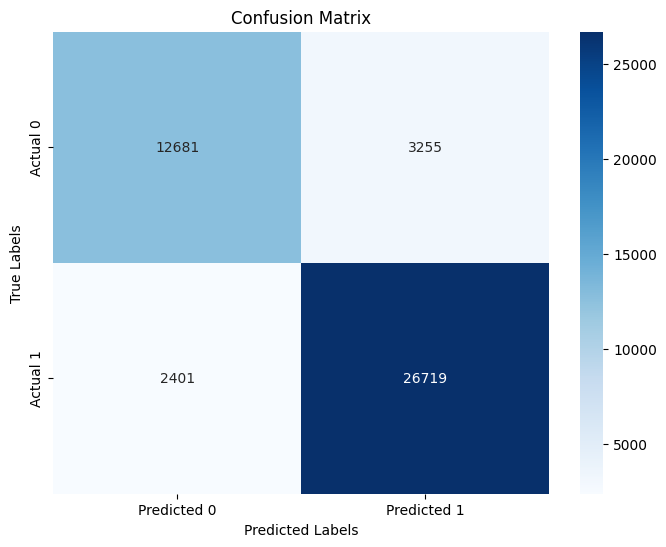

In [38]:
log_pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
log_pipeline.fit(X_train, y_train_log)

y_pred_log = log_pipeline.predict(X_test)

accuracy = accuracy_score(y_test_log, y_pred_log)
precision = precision_score(y_test_log, y_pred_log, average='binary')
recall = recall_score(y_test_log, y_pred_log, average='binary')
f1 = f1_score(y_test_log, y_pred_log, average='binary')
auc = roc_auc_score(y_test_log, y_pred_log)
conf_matrix = confusion_matrix(y_test_log, y_pred_log)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Metrics much better than Linear Regression

### 4.5.3 Ridge Regression


### 4.5.4 Random Forest Classifier 

In [45]:
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1))

rf_param_grid = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation score for Random Forest:", -grid_search_rf.best_score_)

# Evaluate the model on the test set
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)

### 4.5.5 LightLGBM classifier

In [ ]:
from lightgbm import LGBMRegressor

# Define the parameter grid for GridSearchCV
param_grid_lgbm = {
    'lgbmregressor__n_estimators': [100, 200],
    'lgbmregressor__learning_rate': [0.01, 0.1],
    'lgbmregressor__max_depth': [10, 20, -1]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_lgbm.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters for LightGBM:", grid_search_lgbm.best_params_)
print("Best cross-validation score for LightGBM:", -grid_search_lgbm.best_score_)

### 4.5.6 SHAP

## 4.6 Model Evaluation
- Calculate RMSE and R² score

In [55]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

##############

best_model_rf = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

##############

best_model_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_model_lgbm.predict(X_test)


rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM RMSE: {rmse_lgbm}")
print(f"LightGBM R²: {r2_lgbm}")


RMSE: 0.5900673887962733
R²: 0.7370145594825115


## 4.6 Summary

## 4.7 Exports